## 🧲 **Labor Market Tightness**

*Measures employer demand and labor force engagement*
**Frequency:** Monthly

| Indicator                                | Source              |
| ---------------------------------------- | ------------------- |
| Job Openings Rate                        | (`JTSJOL`)    |
| Hires Rate                               | (`JTSHIL`)    |
| Prime-Age Labor Force Participation Rate |(`LNS11300060`) |

In [45]:
import pandas as pd
import sqlite3

# Load CSV files into DataFrames
Job_Openings_Rate_df = pd.read_csv('Job_Openings_Rate.csv')
Hires_Rate_df = pd.read_csv('Hires_Rate.csv')
Prime_Labor_Force_Participation_Rate_df = pd.read_csv('Prime_Labor_Force_Participation_Rate.csv')
Unemployment_Level_df = pd.read_csv('Unemployment_Level.csv')



# Create an SQLite in-memory database
conn = sqlite3.connect(':memory:')

# Load DataFrames into the database as tables
Job_Openings_Rate_df.to_sql('Openings', conn, index=False, if_exists='replace')
Hires_Rate_df.to_sql('Hires', conn, index=False, if_exists='replace')
Prime_Labor_Force_Participation_Rate_df.to_sql('Prime_LFPR', conn, index=False, if_exists='replace')
Unemployment_Level_df.to_sql('Unemployed', conn, index=False, if_exists='replace')



# SQL query to merge all tables on 'Player'
sql_query = """
SELECT 
    Openings.observation_date, 
    JTSHIL AS "Job_Openings_Rate", 
    JTSJOL AS "Hires_Rate", 
    LNS11300060 AS "Prime_LFPR",
    Unemployed.UNEMPLOY AS "Unemployed"
FROM Openings
INNER JOIN Hires ON Openings.observation_date = Hires.observation_date
INNER JOIN Prime_LFPR ON Openings.observation_date = Prime_LFPR.observation_date
INNER JOIN Unemployed ON Openings.observation_date = Unemployed.observation_date
"""


# Execute the query and load results into a DataFrame
Labor_Market_Tightness_df = pd.read_sql_query(sql_query, conn)

# Save the merged DataFrame to a new CSV file
# csv_filename = "Stats/All_Player_Numbers.csv"
# Player_Numbers_df.to_csv(csv_filename, index=False)

# Close the connection
conn.close()

# Provide the file to the user


print(Labor_Market_Tightness_df.columns)


Index(['observation_date', 'Job_Openings_Rate', 'Hires_Rate', 'Prime_LFPR',
       'Unemployed'],
      dtype='object')


**Feature Engineering:**

* `OpeningsPerUnemployed = Job Openings / Unemployed`
* `OpeningsPerHire = Job Openings / Hires`
* `PrimeLFPR_Z = z-score(Prime-Age LFPR)`

<Axes: >

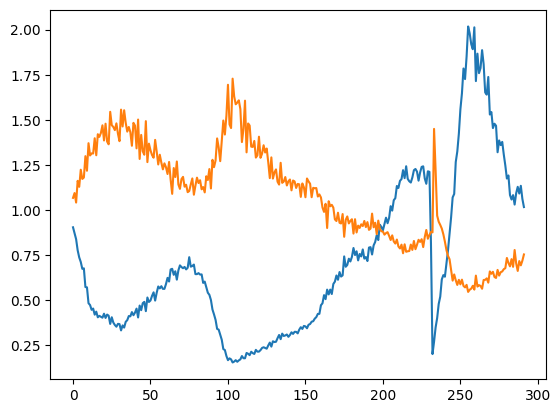

In [55]:
from scipy.stats import zscore

# Demand-side metrics
Labor_Market_Tightness_df['Openings_Per_Unemployed'] = (
    Labor_Market_Tightness_df['Job_Openings_Rate'] / Labor_Market_Tightness_df['Unemployed']
)

Labor_Market_Tightness_df['Openings_Per_Hire'] = (
    Labor_Market_Tightness_df['Job_Openings_Rate'] / Labor_Market_Tightness_df['Hires_Rate']
)

# Supply-side absorption
Labor_Market_Tightness_df['Hires_Per_Unemployed'] = (
    Labor_Market_Tightness_df['Hires_Rate'] / Labor_Market_Tightness_df['Unemployed']
)

# Labor force engagement (already a rate, so z-score directly)
Labor_Market_Tightness_df['Prime_LFPR_ZScore'] = zscore(
    Labor_Market_Tightness_df['Prime_LFPR'], nan_policy='omit'
)

Labor_Market_Tightness_df['Hires_Per_Unemployed'].plot()
Labor_Market_Tightness_df['Openings_Per_Hire'].plot()

**Market Tightness Index (MTI)**

<Axes: >

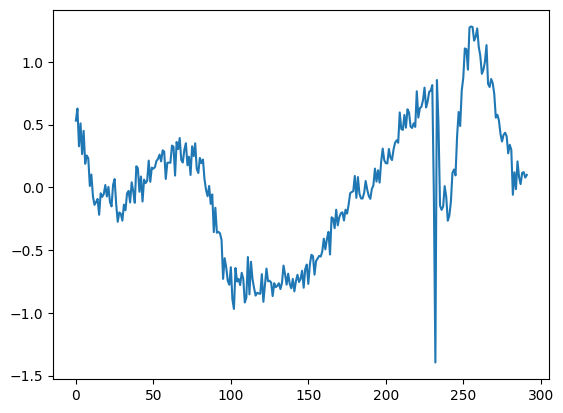

In [53]:
from scipy.stats import zscore

# Combine standardized features into a composite index
Labor_Market_Tightness_df['Labor_Market_Tightness_Index'] = Labor_Market_Tightness_df[[
    'OpeningsPerUnemployed_z',
    'OpeningsPerHire_z',
    'HiresPerUnemployed_z',
    'PrimeLFPR_z'
]].mean(axis=1, skipna=True)

Labor_Market_Tightness_df['Labor_Market_Tightness_Index'].plot()
